#전이학습 과제

In [2]:
# 라이브러리 선언
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
# 모델 구축을 위한 함수 호출
from tensorflow.keras import Sequential, Model, layers
# pre trained model(densenet) 호출
from tensorflow.keras.applications import VGG16
# 데이터 분류를 위한 드라이브 위치 설정
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# pre trained model 적용
vgg_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [4]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# 폴더 라벨별 training, validation set 구축
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
fig_dir='drive/MyDrive/fig'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  fig_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE),
  batch_size=BATCH_SIZE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  fig_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 13344 files belonging to 3 classes.
Using 10676 files for training.
Found 13344 files belonging to 3 classes.
Using 2668 files for validation.


In [6]:
# 클래스 이름 로드
class_names = train_ds.class_names
print(class_names)

['bird', 'cat', 'dog']


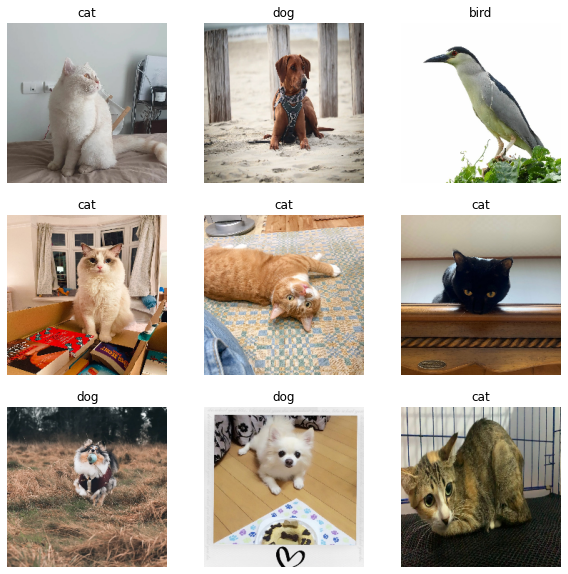

In [7]:
# 라벨, 이미지 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
vgg_res=vgg_model.predict(validation_ds)

In [9]:
# 모델 타입 확인
type(vgg_res)

numpy.ndarray

In [10]:
# 모델 shape 확인
vgg_res.shape

(2668, 7, 7, 512)

In [11]:
# 모델부 weight 유지하면서 Fully connected layer만 학습시키기
vgg_model.trainable = False

In [12]:
# 모델 생성
tr_model = Sequential()
tr_model.add(vgg_model)
tr_model.add(layers.Flatten())
tr_model.add(layers.Dense(256,activation='relu'))
tr_model.add(layers.Dropout(0.5))
# 클래스가 3개 이므로 이에 맞게 설정
tr_model.add(layers.Dense(3,activation='softmax'))
# 모델 형태 확인
tr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
#CNN 모델 컴파일 및 fit
tr_model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])
# 과도학습 방지용 callback 추가
checkpoint_path = '/tmp/checkpoint/models'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
# train dataset을 널어주면 배치단위로 데이터가 넘어가면서 학습
history = tr_model.fit(
  train_ds,  
  validation_data=validation_ds,
  epochs=10,
  callbacks = checkpoint
)

Epoch 1/10
334/334 [==============================] - 766s 2s/step - loss: 3.2380 - accuracy: 0.8498 - val_loss: 0.4522 - val_accuracy: 0.8898
Epoch 2/10
334/334 [==============================] - 129s 380ms/step - loss: 0.3289 - accuracy: 0.8950 - val_loss: 0.2427 - val_accuracy: 0.9224
Epoch 3/10
334/334 [==============================] - 126s 372ms/step - loss: 0.2781 - accuracy: 0.9123 - val_loss: 0.2054 - val_accuracy: 0.9209
Epoch 4/10
334/334 [==============================] - 127s 374ms/step - loss: 0.2457 - accuracy: 0.9269 - val_loss: 0.2048 - val_accuracy: 0.9262
Epoch 5/10
334/334 [==============================] - 124s 364ms/step - loss: 0.2318 - accuracy: 0.9320 - val_loss: 0.2410 - val_accuracy: 0.9220
Epoch 6/10
334/334 [==============================] - 127s 375ms/step - loss: 0.2284 - accuracy: 0.9381 - val_loss: 0.2021 - val_accuracy: 0.9277
Epoch 7/10
334/334 [==============================] - 125s 367ms/step - loss: 0.1936 - accuracy: 0.9426 - val_loss: 0.2429 - va

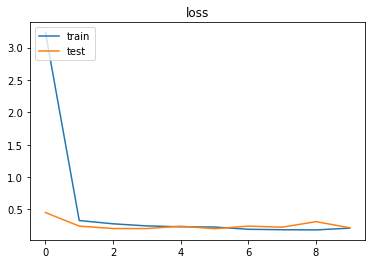

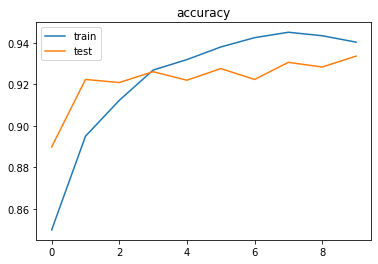

In [17]:
  # epoch별 손실, 정확도 확인
  plt.figure()
  plt.title('loss')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.figure()
  plt.title('accuracy')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train', 'test'], loc='upper left')

In [18]:
# 테스트셋 정확도 평가
validation_loss , validation_acc = tr_model.evaluate(validation_ds)
print('val acc :{} val loss:{}'.format(validation_acc,validation_loss))

84/84 [==============================] - 25s 264ms/step - loss: 0.2172 - accuracy: 0.9337
val acc :0.9336581826210022 val loss:0.21716056764125824


In [19]:
# 모델 저장하기
tr_model.save('/content/drive/MyDrive/2021266973_Baek keun tae_model.h5')

In [20]:
# 함수 설정을 통한 이미지 결과 예측 및 분류
def preprocessing(file, width = 224, height = 224):
  img = cv2.imread(file)
  img = cv2.resize(img, dsize=(width, height))
  cv2_imshow(img)
  imgs = np.expand_dims(img, 0)
  return imgs

def predict_ani(imgs, class_label):
  pred = tr_model.predict(imgs)
  res = np.argmax(pred)
  return class_label[res]

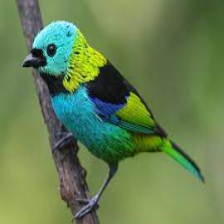

'bird'

In [21]:
# 외부 이미지 1번 테스트
file = '/content/drive/My Drive/test/bird_images.jpg'
predict_ani(preprocessing(file), class_names)

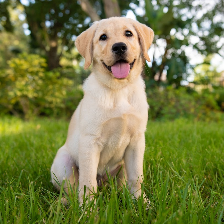

'dog'

In [22]:
# 외부 이미지 2번 테스트
file = '/content/drive/My Drive/test/dog_images.jpg'
predict_ani(preprocessing(file), class_names)

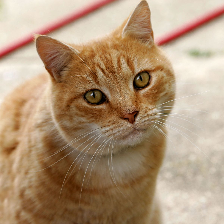

'cat'

In [23]:
# 외부 이미지 3번 테스트
file = '/content/drive/My Drive/test/cat_images.jpg'
predict_ani(preprocessing(file), class_names)